# Load modules

In [3]:
import numpy as np
import pandas as pd
import os, sys, cv2, pickle
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import random, itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, hamming_loss

from keras.utils import to_categorical
from keras.models import Model
from keras import regularizers
import keras.utils.np_utils as kutils
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Load datasets

In [4]:
train = pd.read_csv("../data/train.csv", sep=",")
test = pd.read_csv("../data/test.csv", sep=",")
dig_mnist = pd.read_csv("../data/Dig-MNIST.csv", sep=",")
sample_submission = pd.read_csv("../data/sample_submission.csv", sep=",")

# Get Class to create array for model

In [5]:
class Create_Array:
    def __init__(self, data, random_sample, random_state):
        self.random_sample = random_sample
        self.random_state = random_state
        if random_sample == 1: self.data = data
        else:
            train_X, test_X, train_y, test_y = \
            train_test_split(data, data.label, test_size=random_sample, random_state=random_state, stratify=data.label)
            test_X['label'] = test_y
            self.data = test_X.reset_index(drop="index")
    def split_data(self, test_size, to_category):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = \
        train_test_split(self.data.drop(columns="label"), self.data.label, test_size=test_size, random_state=self.random_state, stratify=self.data.label)
        train_X = train_X.reset_index(drop='index')
        self.train_X = self.change_format_X(train_X)
        test_X = test_X.reset_index(drop='index')
        self.test_X = self.change_format_X(test_X)
        train_y = train_y.reset_index(drop='index')
        self.train_y = self.change_format_y(train_y, to_category)
        test_y = test_y.reset_index(drop='index')
        self.test_y = self.change_format_y(test_y, to_category)
    def get_pie_chart(self, figsize):
        label_dict = dict()
        label_count = self.data.label.value_counts()
        for k in label_count.index:
            label_dict[label_count.index[k]] = label_count[k]
        
        def func(pct, allvals):
            absolute = int(pct/100.*np.sum(allvals))
            return "{:0.0f}\n{:0.2f} %".format(absolute, pct)
        
        data = list(label_dict.values())
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                          textprops=dict(color="w"))
        ax.legend(wedges, label_dict.keys(),
                  title="Labels",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))
        return fig
    def show_one_image(self, figsize):
        plt.figure(figsize=figsize)
        ind = random.sample(k=1, population=set(self.data.index))
        img = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.imshow(img)
        plt.title("label : {}".format(self.data.loc[ind[0]]["label"]))
        return plt
    def show_multiple_images(self, seed, figsize, show_plot):
        random.seed(seed)
        num_dict = dict()
        for num in range(10):
            ind = random.sample(k=1, population=set(self.data.loc[self.data.label==num].index))
            num_dict[self.data.label[ind[0]]] = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        self.num_dict = num_dict
        if show_plot:
            fig = plt.figure(figsize=figsize)
            for k,v in num_dict.items():
                ax = fig.add_subplot(5, 5, 1 + k)
                ax.imshow(num_dict[k])
                ax.title.set_text("label : {}".format(k))
    def change_format_X(self, data):
        #return data.values.reshape(data.shape[0], 28, 28, 1)
        return data.values.reshape(data.shape[0], 28, 28).reshape(data.shape[0], 28, 28, 1)
    def change_format_y(self, data, to_category):
        self.to_category = to_category
        #pbar = ProgressBar()
        #data_copy = data.copy()
        y = []
        if to_category:
            for k in data.index:
                y.append([data.loc[k]])
            y = to_categorical(y)
        else:
            for k in data.index:
                y.append(data.loc[k])
            y = np.array(y)
        return y

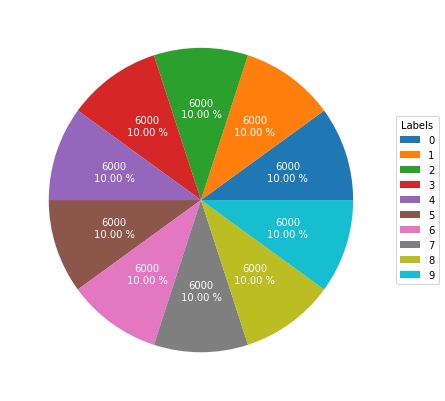

In [6]:
dat = Create_Array(train, 1, 123)
_ = dat.get_pie_chart(figsize=(10,7))

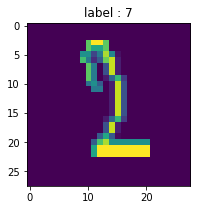

In [7]:
_ = dat.show_one_image(figsize=(3,3))

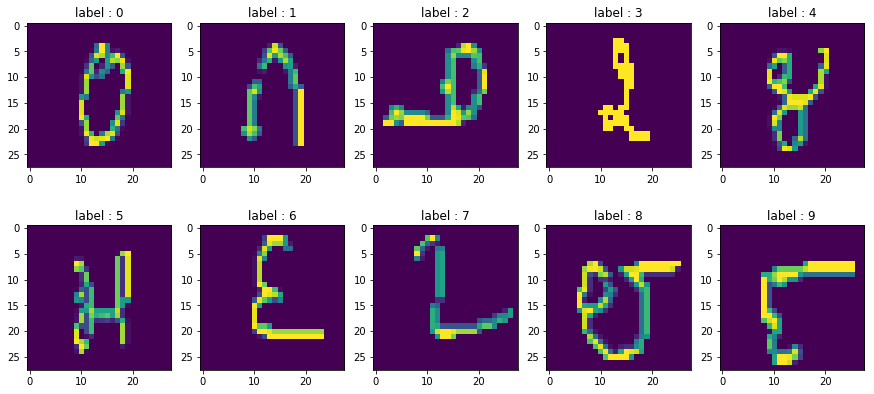

In [8]:
dat.show_multiple_images(figsize=(15,18), seed=93, show_plot=True)

In [9]:
# split the dataset
dat.split_data(test_size=0.15, to_category=False)

In [10]:
print("dimension of train : {}".format(dat.train_X.shape))
print("dimension of test : {}".format(dat.test_X.shape))

dimension of train : (51000, 28, 28, 1)
dimension of test : (9000, 28, 28, 1)


# Create model of cnn

In [11]:
# History plot
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid(True)
    
    #plt.figure()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    
    #plt.show()
    return plt

In [12]:
# Confusion matrix
def get_confusion_matrix(Y, y_pred, figsize=(7,7), dpi=90, normalize=False, cmap=plt.cm.Blues):
        cnf_matrix = confusion_matrix(Y, y_pred)
        acc = metrics.accuracy_score(Y, y_pred)
        
        if normalize:
            cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        
        plt.figure(figsize=figsize, dpi=dpi)
        plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
        title = 'Confusion matrix\nAccuracy : {} %'.format(np.round(100*acc,2))
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(10)
        xtick = [t for t in range(10)]
        plt.xticks(tick_marks, xtick, rotation=0)
        plt.yticks(tick_marks, xtick)
        
        fmt = '.2f' if normalize else 'd'
        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return plt

In [13]:
import skimage.transform
import skimage.util
from skimage.io import imread

def rotation_and_shear(img, rotation_angle=15, shear_angle=30):
    img = skimage.transform.rotate(img, np.random.randint(-rotation_angle, rotation_angle))
    tf_shift = skimage.transform.SimilarityTransform(translation=(-14, -14))
    tf_inv_shift = skimage.transform.SimilarityTransform(translation=(14, 14))
    tf_shear = skimage.transform.AffineTransform(shear=np.deg2rad(np.random.randint(-shear_angle, shear_angle)))
    img = skimage.transform.warp(img, (tf_shift + (tf_shear + tf_inv_shift)).inverse)
    return img

def shift_pixels(img, shift_range=1):
    tf_shift = skimage.transform.SimilarityTransform(translation=(np.random.randint(-shift_range, shift_range), np.random.randint(-shift_range, shift_range)))
    img = skimage.transform.warp(img, tf_shift)
    return img

def add_noise(img, gauss_var=0.02):
    #img = skimage.util.random_noise(img, mode='pepper', amount=0.1)
    img = skimage.util.random_noise(img, mode='gaussian', var=gauss_var)
    return img

def batch_generator(trainX, trainY, batch_size):
    while True:
        idxs = np.arange(0, trainY.shape[0])
        np.random.shuffle(idxs)
        for i in range(trainY.shape[0] // batch_size):
            batchX = [trainX[idx] for idx in idxs[i * batch_size : (i+1) * batch_size]]
            batchY = [trainY[idx] for idx in idxs[i * batch_size : (i+1) * batch_size]]
            batchX = [add_noise(rotation_and_shear(img[0])) for img in batchX]
            batchX = np.array(batchX)
            batchX = batchX.reshape(batchX.shape[0], 1, batchX.shape[1], batchX.shape[2])
            yield batchX, np.array(batchY)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import ZeroPadding2D, Convolution2D, MaxPooling2D, Conv2D
from keras.layers import BatchNormalization

model = Sequential()
#model.add(ZeroPadding2D((2,2)))
model.add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1),padding="same"))
model.add(ZeroPadding2D((2,2)))
model.add(Conv2D(64,kernel_size=5,activation='relu'))
model.add(MaxPooling2D(strides=(2,2)))

model.add(ZeroPadding2D((2,2)))
model.add(Conv2D(256,kernel_size=5,activation='relu',init='he_normal'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256,kernel_size=3,activation='relu',init='he_normal'))
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.2))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512,kernel_size=3,activation='relu',init='he_normal'))
model.add(Dropout(0.2))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512,kernel_size=3,activation='relu',init='he_normal'))
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1024, activation='relu', init='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu', init='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        shear_range=20, #move top of image along without moving the bottom or vice versa
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        data_format="channels_last" #per theano convention, tensorflow is channels_first 
        )

In [ ]:
### from keras.models import Sequential
### from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
### # Creating a Sequential Model and adding the layers
### model = Sequential()
### 
### model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
### model.add(BatchNormalization())
### model.add(Conv2D(32,kernel_size=3,activation='relu'))
### model.add(BatchNormalization())
### model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
### model.add(BatchNormalization())
### model.add(Dropout(0.4))
### 
### model.add(Conv2D(64,kernel_size=3,activation='relu'))
### model.add(BatchNormalization())
### model.add(Conv2D(64,kernel_size=3,activation='relu'))
### model.add(BatchNormalization())
### model.add(Conv2D(64,kernel_size=3,activation='relu'))
### model.add(BatchNormalization())
### model.add(Conv2D(64,kernel_size=3,activation='relu'))
### model.add(BatchNormalization())
### model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
### model.add(BatchNormalization())
### model.add(Dropout(0.5))
### 
### model.add(Flatten())
### model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)))
### model.add(BatchNormalization())
### model.add(Dropout(0.5))
### model.add(Dense(10, activation='softmax'))

In [ ]:
### # Reshaping the array to 4-dims so that it can work with the Keras API
### x_train = dat.train_X
### x_test = dat.test_X
### y_train = dat.train_y
### y_test = dat.test_y
### input_shape = (1, 28, 28)
### # Making sure that the values are float so that we can get decimal points after division
### x_train = x_train.astype('float32')
### x_test = x_test.astype('float32')
### # Normalizing the RGB codes by dividing it to the max RGB value.
### x_train /= 255
### x_test /= 255

In [ ]:
from __future__ import division
import numpy as np

import cv2

import skimage.measure

def crop_image(img, threshold=0):
    rows = np.where(np.max(img, 0) > threshold)[0]
    cols = np.where(np.max(img, 1) > threshold)[0]
    img = img[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    return img

def get_square_image(img):
    if img.shape[0] > img.shape[1]:
        pad_up = (img.shape[0] - img.shape[1]) // 2
        pad_bottom = np.ceil((img.shape[0] - img.shape[1]) / 2).astype('int32')
        img = np.pad(img, ((0, 0), (pad_up, pad_bottom)), 'constant', constant_values=0)
        return img
    else:
        pad_left = (img.shape[1] - img.shape[0]) // 2
        pad_right = np.ceil((img.shape[1] - img.shape[0]) / 2).astype('int32')
        img = np.pad(img, ((pad_left, pad_right), (0, 0)), 'constant', constant_values=0)
        return img

def add_padding(img, paddding_size=4):
    return np.pad(img, ((paddding_size, paddding_size), (paddding_size, paddding_size)), 'constant', constant_values=0)

# Aspect Ratio Adaptive Normalization
def get_new_aspect_ratio(img):
    if img.shape[0] > img.shape[1]:
        return np.sqrt(np.sin((img.shape[1] / img.shape[0]) * (np.pi / 2)))
    else:
        return np.sqrt(np.sin((img.shape[0] / img.shape[1]) * (np.pi / 2)))

def linear_normalization(img):
    aspect_ratio = get_new_aspect_ratio(img)
    new_size = 20
    width = new_size if img.shape[0] > img.shape[1] else int(aspect_ratio * new_size)
    height = new_size if img.shape[1] > img.shape[0] else int(aspect_ratio * new_size)
    x_points = np.round(np.array(range(width)) * (float(img.shape[0]-1) / (width-1))).astype('int32')
    y_points = np.round(np.array(range(height)) * (float(img.shape[1]-1) / (height-1))).astype('int32')
    new_img = img[np.ix_(x_points, y_points)]
    return new_img

def lagrange_mapping(position, centroid, centroid2, orig_size, delta, delta2, deltacentroid):
    lag = ((2 * orig_size) * (position**2 - 2*position*centroid + centroid2 + (delta*position - deltacentroid)/2) - (4*centroid) * (position**2 + centroid2 - (delta2/4) - 2*position*centroid)) / delta2
    return lag

def moment_normalization(img):
    # moments
    moments = skimage.measure.moments(img, 2)
    centroid = [moments[0, 1] / moments[0, 0], moments[1, 0] / moments[0, 0]]
    central_moments = skimage.measure.moments_central(img, centroid[0], centroid[1], 2)
    delta_y = 4 * np.sqrt(central_moments[0, 2])
    delta_x = 4 * np.sqrt(central_moments[2, 0])
    delta_y2 = delta_y ** 2
    delta_x2 = delta_x ** 2
    delta_cent_y = delta_y * centroid[1]
    delta_cent_x = delta_x * centroid[0]
    centroid2 = np.power(centroid, 2)

    # Calculate new width and height
    aspect_ratio = get_new_aspect_ratio(img)
    new_size = 20
    width = new_size if img.shape[0] > img.shape[1] else int(aspect_ratio * new_size)
    height = new_size if img.shape[1] > img.shape[0] else int(aspect_ratio * new_size)

    x_points = np.array(range(width))
    y_points = np.array(range(height))
    xx = ((delta_x * (x_points - (width-1)/2)) / (width-1)) + centroid[0]
    yy = ((delta_y * (y_points - (height-1)/2)) / (height-1)) + centroid[1] 
    xx = np.round(lagrange_mapping(xx, centroid[0], centroid2[0], img.shape[0]-1, delta_x, delta_x2, delta_cent_x)).astype('int32')
    yy = np.round(lagrange_mapping(yy, centroid[1], centroid2[1], img.shape[1]-1, delta_y, delta_y2, delta_cent_y)).astype('int32')
    xx = np.clip(xx, 0, img.shape[0]-1)
    yy = np.clip(yy, 0, img.shape[1]-1)
    new_img = img[np.ix_(xx, yy)]
    return new_img

def normalize_shape(img):
    img = crop_image(img)
    img = moment_normalization(img)
    img = get_square_image(img)
    img = add_padding(img)
    return img

def preprocess_image(img):
    img = normalize_shape(img)
    #img = cv2.GaussianBlur(img, (1, 1), 0)
    return img

In [ ]:
x_train = train.loc[:,"pixel0":].values.reshape(train.shape[0], 1, 28, 28)
x_train = x_train.astype(float)
x_train /= 255.0
x_train = np.array([preprocess_image(x[0]).reshape(1, 28, 28) for x in x_train])

print(x_train.shape)

#y_train = kutils.to_categorical(train.label.values)
#nb_classes = y_train.shape[1]
y_train = train.label.values

# Split the training data into training and validation data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, random_state=20191031)

In [ ]:
# print the model
model.summary()

In [ ]:
# fit the cnn model
from keras.callbacks import ReduceLROnPlateau
import keras.optimizers as opt

def fit_model(model, epoch, batch_size):
    # set up the optimizer
    adam = opt.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # reduce the learning rate by factor of 0.5 if the validation loss does not get lower in 7 epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.0000001, verbose=1)
    
    history = model.fit_generator(datagen.flow(x_train.reshape(x_train.shape[0],28,28).reshape(x_train.shape[0],28,28,1),y_train,batch_size=batch_size), validation_data=(x_test.reshape(x_test.shape[0],28,28).reshape(x_test.shape[0],28,28,1), y_test),
                                  samples_per_epoch=np.floor(y_train.shape[0] / batch_size) * batch_size,
                                  nb_epoch=epoch, verbose=1, callbacks=[reduce_lr])
    
    #history = model.fit(x_train.reshape(x_train.shape[0],28,28).reshape(x_train.shape[0],28,28,1), y_train,
    #                    nb_epoch=epoch,
    #                    batch_size=batch_size,
    #                    validation_data=(x_test.reshape(x_test.shape[0],28,28).reshape(x_test.shape[0],28,28,1), y_test),
    #                    verbose=1)
    return model, history

In [ ]:
model, history = fit_model(model=model, epoch=100, batch_size=64)

In [ ]:
_ = history_plot(history)

In [ ]:
print("evaluation in train : ")
eval_train = model.evaluate(x_train.reshape(x_train.shape[0],28,28).reshape(x_train.shape[0],28,28,1), y_train)
print(eval_train)
print("evaluation in test : ")
eval_test = model.evaluate(x_test.reshape(x_test.shape[0],28,28).reshape(x_test.shape[0],28,28,1), y_test)
print(eval_test)

In [ ]:
from numpy import argmax
# Confusion matrix in test
predicted_test = model.predict_classes(x_test.reshape(x_test.shape[0],28,28).reshape(x_test.shape[0],28,28,1))
_ = get_confusion_matrix(Y=y_test, y_pred=predicted_test, normalize=False, dpi=75, figsize=(7,7))

In [ ]:
def show_multiple_images_predicted(num_dict, model, figsize):
    label_predicted = dict()
    for lab_ref,img in num_dict.items():
        lab_pred = model.predict_classes(img.reshape(1, 28, 28).reshape(1, 28, 28, 1))[0]
        label_predicted[lab_ref] = lab_pred
    fig = plt.figure(figsize=figsize)
    for l_ref,l_pred in label_predicted.items():
        ax = fig.add_subplot(5, 5, 1 + l_ref)
        ax.imshow(num_dict[l_ref])
        ax.title.set_text("label : {}\npredicted : {}".format(l_ref,l_pred))

In [ ]:
dat.show_multiple_images(figsize=(15,18), seed=1265439, show_plot=False)
show_multiple_images_predicted(dat.num_dict, model, (15,20))

# Prediction on the test set

In [ ]:
### test_to_predict = test.drop(columns=['id'])
### test_to_predict = test_to_predict.astype('float32')
### test_to_predict /= 255
### 
### label_predicted = \
### model.predict_classes(test_to_predict.values.reshape(test_to_predict.shape[0], 28, 28).reshape(test_to_predict.shape[0], 28, 28, 1))
### 
### test_predicted = test.copy()
### test_predicted['label'] = label_predicted
### 
### submission = test_predicted[["id", "label"]]

In [ ]:
test_to_predict = test.loc[:,"pixel0":].values.reshape(test.shape[0], 1, 28, 28)
test_to_predict = test_to_predict.astype(float)
test_to_predict /= 255.0
test_to_predict = np.array([preprocess_image(x[0]).reshape(1, 28, 28) for x in test_to_predict])

label_predicted = \
model.predict_classes(test_to_predict.reshape(test_to_predict.shape[0], 28, 28).reshape(test_to_predict.shape[0], 28, 28, 1))

test_predicted = test.copy()
test_predicted['label'] = label_predicted

submission = test_predicted[["id", "label"]]

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.groupby(['label'])['label'].count()

In [ ]:
def show_images_on_test(data, seed, figsize):
    random.seed(seed)
    ind = random.sample(k=10, population=set(data.id))
    img = data.drop(columns=['id','label'])
    label = data['label']
    id_img = data['id']
    fig = plt.figure(figsize=figsize)
    for k in range(len(ind)):
        ax = fig.add_subplot(5, 5, 1 + k)
        img_k = img.loc[ind[k]].values.reshape(28,28)
        ax.imshow(img_k)
        ax.title.set_text("label : {}\nid : {}".format(label[ind[k]],id_img[ind[k]]))
    return plt

In [ ]:
_ = show_images_on_test(test_predicted, 99999, (15,18))